In [21]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from variational import *
from normalizing_flow import *

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [22]:
N_TOT = mnist.train.images.shape[0]

# Since we use logit-normal model make sure
# 0. and 1. done't appear in images by adding/subtracting
# epsilon
mnist.train.images[mnist.train.images == 0.] += 0.001
mnist.train.images[mnist.train.images == 1.] -= 0.001

In [23]:
def shuffled_batch_idx(n_examples, batch_size):
    shuffle_idx = np.random.choice(
        n_examples, n_examples, replace=False)
    rounded = n_examples - n_examples % batch_size
    shuffle_idx = shuffle_idx[:rounded]
    return list(shuffle_idx.reshape([rounded // batch_size, batch_size]))

def logit(x):
    return tf.log(x / (1 - x))

In [41]:
NORM_FLOW = False
LOGIT_NORMAL = False

BATCH_EX = 1
MC_EX = 10
lat_dim = 2
obs_dim = 28 * 28

graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(dtype=tf.float64, shape=[BATCH_EX, obs_dim], name='input')
    if NORM_FLOW:
        encoder = FlowConditionalVariable(
            dim_x=lat_dim, y=x, flow_layers=1, hidden_units=[512, 256, 128, 64])
        z, log_q = encoder.sample_log_prob(n_samples=MC_EX)
    else:
        # Standard reparametrized normal
        encoder = tf.squeeze(
            MultiLayerPerceptron(x, layers=[512, 256, lat_dim], activation=tf.nn.relu).get_output_layer())
        encoder_noise = tf.squeeze(
            MultiLayerPerceptron(x, layers=[512, 256, lat_dim], activation=tf.nn.relu).get_output_layer()) + 0.01
        q = tf.distributions.Normal(loc=encoder, scale=tf.square(encoder_noise))
        z = q.sample(MC_EX)
        if BATCH_EX > 1:
            log_q = tf.transpose(tf.reduce_sum(q.log_prob(z), axis=2))
            z = tf.transpose(z, [1, 0, 2])
        else:
            log_q = tf.reduce_sum(q.log_prob(z), axis=1)

    # The decoder is a reparametrized logit_Normal because images [0., 1.]
    decoder = tf.squeeze(
        MultiLayerPerceptron(z, layers=[256, 256, obs_dim], activation=tf.nn.relu).get_output_layer())
    decoder_noise = tf.squeeze(
        MultiLayerPerceptron(z, layers=[256, 256, obs_dim], activation=tf.nn.relu).get_output_layer()) + 0.01
    p = tf.distributions.Normal(loc=decoder, scale=tf.square(decoder_noise))
    if LOGIT_NORMAL:
        x_hat = tf.squeeze(tf.nn.sigmoid(p.sample(1)))
    else:
        x_hat = tf.squeeze(p.sample(1))

    prior = tf.distributions.Normal(loc=np.zeros(lat_dim), scale=np.ones(lat_dim))

    # ELBO
    if BATCH_EX == 1:
        if LOGIT_NORMAL:
            log_like = p.log_prob(logit(x)) - tf.log(x) - tf.log(1 - x)
        else:
            log_like = p.log_prob(x)
        loss = tf.reduce_sum(
            - tf.reduce_sum(log_like, axis=1) - tf.reduce_sum(prior.log_prob(z), axis=1) + log_q)
    else:
        exp_x = tf.expand_dims(x, 1)
        if LOGIT_NORMAL:
            log_like = p.log_prob(logit(exp_x)) - tf.log(exp_x) - tf.log(1 - exp_x)
        else:
            log_like = p.log_prob(exp_x)
        loss = tf.reduce_sum(
            - tf.reduce_sum(log_like, axis=2) - tf.reduce_sum(prior.log_prob(z), axis=2) + log_q)

    # Choose the optimization algorithm to use
    train_op = tf.train.AdagradOptimizer(learning_rate=.001).minimize(loss)
    #train_op = tf.train.AdamOptimizer(learning_rate=.005).minimize(loss)

    my_sess = tf.Session()
    my_sess.run(tf.global_variables_initializer())

losses = []
TOT_ITERATIONS = 0

In [33]:
N_STEPS = 55000

shuffle_idx = []
with graph.as_default():
    for i in tqdm(range(N_STEPS)):
        if shuffle_idx == []:
            shuffle_idx = shuffled_batch_idx(N_TOT, BATCH_EX)
        idx = shuffle_idx.pop()
        observation = mnist.train.images[idx, :]
        _, elbo = my_sess.run(
            [train_op, loss], feed_dict={'input:0': observation})
        losses.append(elbo)
        TOT_ITERATIONS += 1

100%|██████████| 55000/55000 [05:40<00:00, 161.59it/s]


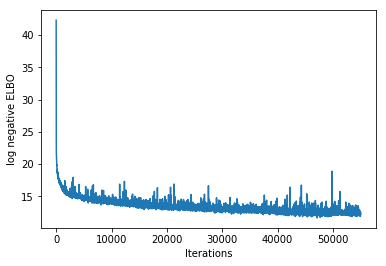

In [38]:
skip_ = 10
iterations_ = np.arange(0, TOT_ITERATIONS, skip_).astype('int')
log_losses = np.log(np.mean(np.reshape(
    np.array(losses), [len(losses)/skip_, skip_]), axis=1))
plt.plot(iterations_, log_losses)
plt.xlabel('Iterations')
plt.ylabel('log negative ELBO')
plt.show()

# Latent Probabilistic Codes of Digits

In [35]:
recs = []
codes = []
i = 0
pbar = tqdm(total=N_TOT)
with graph.as_default():
    while i < N_TOT:
        pbar.update(BATCH_EX)
        observation = mnist.train.images[i:i+BATCH_EX, :]
        code_, rec_ = my_sess.run(
            [z, x_hat], feed_dict={'input:0': observation})
        if BATCH_EX == 1:
            recs.append(rec_)
            codes.append(code_)
        else:
            for j in range(rec_.shape[0]):
                recs.append(rec_[j, :, :])
                codes.append(code_[j, :, :])
        i += BATCH_EX

pbar.close()

100%|██████████| 55000/55000 [03:29<00:00, 262.80it/s]


In [36]:
codes1 = np.squeeze(np.array(codes)[:, 1, :])
recs1 = np.squeeze(np.array(recs)[:, 1, :])
recs1.shape

(55000, 784)

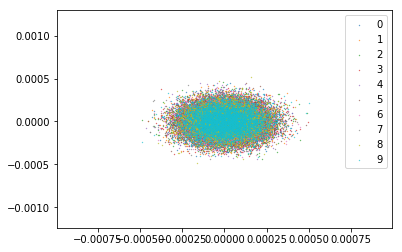

In [37]:
from  sklearn.decomposition import PCA
idx = []

codes = np.array(codes)

pca = PCA(n_components=2)
x_ = pca.fit_transform(np.squeeze(codes[:, 0, :]))

for i in range(0, 10):
    idx.append(mnist.train.labels[:, i] == 1)

for i in range(0, 10):
    plt.scatter(x_[idx[i], 0], x_[idx[i], 1], s=0.1)
#plt.xlim(-40, 40)
#plt.ylim(-20, 20)
plt.legend(range(0, 10))
plt.show()

# Samples from the Generative Model

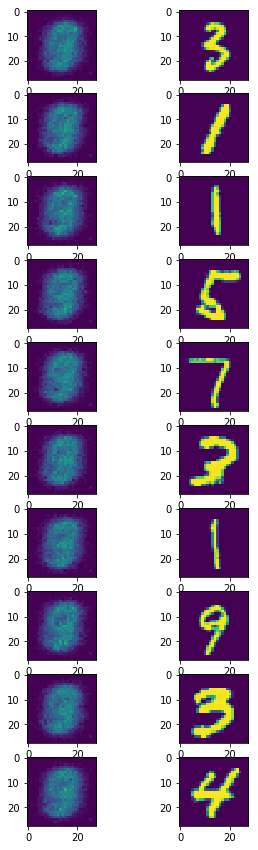

In [39]:
off_set = 40000
fig, ax = plt.subplots(10, 2)
for j in range(10):
    ax[j, 0].imshow(np.reshape(recs[off_set + j][0, :], [28, 28]), vmin=0, vmax=1)
    ax[j, 1].imshow(np.reshape(mnist.train.images[off_set + j, :], [28, 28]), vmin=0, vmax=1)
fig.set_size_inches(5, 15)
plt.show()

In [33]:
my_sess.close()
